# Create translation tests for Web2Cit

This notebook performs automatic creation of [Web2Cit](https://meta.wikimedia.org/wiki/Web2Cit) translation test files for the web domains evaluated in [understand-citoid-coverage.ipynb](https://github.com/hdcaicyt/Web2Cit-research/blob/main/understand-citoid-coverage.ipynb). 

Translation tests represent the expected output for specific target webpages, so the metadata contained in the translation test files must be correct and accurate. We use as input the citation metadata extracted from EN, ES, FR and PT Wikipedia's featured articles (which is assumed to be correct).

See [Web2Cit research project report](https://meta.wikimedia.org/wiki/Web2Cit/Research/report) for more information about this task and our methodological assumptions.

__Author:__

* Nidia Hernández, [nidiahernandez@conicet.gov.ar](mailto:nidiahy@gmail.com), CAICYT-CONICET


### Table of contents

1. Web2Cit's translation tests
2. Evaluated domains data
3. Select manual citations
4. Recover metadata without preprocessing
5. Build translation tests files
6. Upload files

In [1]:
import os
import pandas as pd
from operator import itemgetter
import json
import gzip
from glob import glob
from pprint import pprint
from tqdm import tqdm
tqdm.pandas()
from urllib.parse import urlparse
import requests
from pprint import pprint
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

/home/yoki/anaconda3/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
In /home/yoki/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/yoki/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/yoki/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/yoki/anaconda3/lib/python3.7/site-packages/matplotl

In [2]:
METAWIKIMEDIA_API_URL = f'https://meta.wikimedia.org/w/api.php?'
HEADER={'User-Agent': 'http://caicyt-conicet.gov.ar/; mailto:nidiahernandez@conicet.gov.ar'}

## 1. Web2Cit's translation tests

Web2Cit's translation tests represent the expected citation output for specific target webpages. These translation tests may help Web2Cit contributors identify websites having problems with Citoid and fix them with Web2Cit.

More information at:

- https://meta.wikimedia.org/wiki/Web2Cit/Docs/Tests
- https://meta.wikimedia.org/wiki/Web2Cit/Docs/Storage#tests.json

Let's query https://meta.wikimedia.org/wiki/Web2Cit/data to check the currently available translation test files:

In [3]:
PARAMS = {
    "action": "query",
    "format": "json",
    "list": "prefixsearch",
    "pssearch": "Web2Cit/data",
    "pslimit": "max", 
    "curtimestamp": True
}

response = requests.get(
    url=METAWIKIMEDIA_API_URL, 
    params=PARAMS,
    headers=HEADER
)

data = response.json()

In [4]:
existing_files = []

for page in data['query']['prefixsearch']:
    if page['title'].endswith('tests.json'):
        existing_files.append(page['title'])

In [5]:
print(f"There are {len(existing_files)} translation tests on {data['curtimestamp']}")

There are 30 translation tests on 2022-10-31T19:47:50Z


In [7]:
existing_files

['Web2Cit/data/fr/lejdd/www/tests.json',
 'Web2Cit/data/hu/5percado/tests.json',
 'Web2Cit/data/ro/mediafax/www/tests.json',
 'Web2Cit/data/com/nbcnews/www/tests.json',
 'Web2Cit/data/ar/com/lavoz/www/tests.json',
 'Web2Cit/data/com/aljazeera/www/tests.json',
 'Web2Cit/data/org/cjr/www/tests.json',
 'Web2Cit/data/uy/com/montevideo/www/tests.json',
 'Web2Cit/data/au/gov/qld/qagoma/blog/tests.json',
 'Web2Cit/data/uk/gov/www/tests.json',
 'Web2Cit/data/com/3rionoticias/tests.json',
 'Web2Cit/data/com/revistaanfibia/tests.json',
 'Web2Cit/data/br/com/uol/folha/www1/tests.json',
 'Web2Cit/data/com/newyorker/www/tests.json',
 'Web2Cit/data/org/amnesty/www/tests.json',
 'Web2Cit/data/uy/com/ladiaria/tests.json',
 'Web2Cit/data/org/adl/www/tests.json',
 'Web2Cit/data/ie/independent/www/tests.json',
 'Web2Cit/data/com/go/abcnews/tests.json',
 'Web2Cit/data/ie/rte/www/tests.json',
 'Web2Cit/data/uy/com/elpais/www/tests.json',
 'Web2Cit/data/au/gov/qld/goldcoast/digitalbank/tests.json',
 'Web2Ci

This is how a translation test file looks like:

In [8]:
PARAMS = {
    "action": "parse",
    "page": "Web2Cit/data/com/nbcnews/www/tests.json",
    "prop": "wikitext",
    "format": "json"
}

response = requests.get(
    url=METAWIKIMEDIA_API_URL, 
    params=PARAMS,
    headers=HEADER
)

page_data = response.json()

print(page_data['parse']['wikitext']['*'])

[
  {
    "path": "/business/economy/july-inflation-numbers-consumer-prices-rose-85-year-year-summer-inflat-rcna42393",
    "fields": [
      {
        "fieldname": "itemType",
        "goal": [
          "newspaperArticle"
        ]
      },
      {
        "fieldname": "title",
        "goal": [
          "Consumer prices rose by 8.5% year over year in July as the summer of inflation wears on"
        ]
      },
      {
        "fieldname": "authorLast",
        "goal": [
          "Rob Wile"
        ]
      },
      {
        "fieldname": "date",
        "goal": [
          "2022-08-10"
        ]
      },
      {
        "fieldname": "publishedIn",
        "goal": [
          "NBC News"
        ]
      },
      {
        "fieldname": "language",
        "goal": [
          "en"
        ]
      }
    ]
  }
]


Some information about the fieldnames of the translation test files :

* itemType: mandatory. Single value
* title: mandatory. Single value, empty string not allowed.
* authorLast: may have multiple values. Can be last name(s) or full name(s).
* authorFirst: may have multiple values.
* date: single value. YYYY-MM-DD, YYYY-MM or YYYY format
* publishedBy: single value.
* publishedIn: single value.
* language: single value.

More information at: https://meta.wikimedia.org/wiki/Web2Cit/Docs/Fields

We will extract the data for these fields from the following columns in our evaluation dataframe:

* itemType: will not be extracted because in the results of the Citoid's evaluation research we observed that it is not reliable information even if there is a match between Citoid data and manual data (see [Web2Cit Research report](https://meta.wikimedia.org/wiki/Web2Cit/Research/report))
* title: title_manual
* authorLast: author_last_manual
* authorFirst: author_first_manual
* date: pub_date_manual
* publishedBy: can't be recovered, pub_source_manual is a mix of publishedBy and publishedIn
* publishedIn: can't be recovered, see above
* language: can't be recovered, we do not have the publishing languaage in our df

## 2. Evaluated domains data

Our goal is to automatically produce new translation tests for Web2cit. We will use as input the citation metadata extracted from the citations in EN, ES, FR and PT Wikipedia's featured articles and we will select the citations based on the results of Citoid's evaluation by domain obtained in [Understand Citoid coverage](https://github.com/hdcaicyt/Web2Cit-research/blob/main/understand-citoid-coverage.ipynb) notebook.

In [9]:
## Read evaluation results df
citoid_eval = pd.read_csv("eval/eval_all_citations.csv.gz")
manual_metadata = ['title_manual', 'author_last_manual', 'author_first_manual', 'pub_date_manual'] # 'pub_source' will not be used, it can't be mapped

# read data as lists
for col in manual_metadata:
    citoid_eval[col] = citoid_eval[col].fillna('None').map(eval)

In [10]:
print(f"There are {len(citoid_eval)} citations in our evaluation corpus")

There are 91338 citations in our evaluation corpus


In [11]:
citoid_eval.head()

,url,url_citoid,source_type_citoid,title_citoid,author_first_citoid,author_last_citoid,pub_date_citoid,pub_source_citoid,citation_template,source_type_manual,...,article_url,page_id,revid,wiki_lang,comp_title,comp_source_type,comp_pub_source,comp_pub_date,comp_author_first,comp_author_last
0,https://www.theage.com.au/entertainment/movies...,https://www.theage.com.au/entertainment/movies...,webpage,bollywood on bourke street,NaN,NaN,2005-05-13,the age,cite news,"['magazineArticle', 'newspaperArticle']",...,https://en.wikipedia.org/wiki/Preity%20Zinta,415405,1070334117,en,1.00,0,0.00,1.0,1.0,0.00
1,https://books.google.com/books?id=QSwEAAAAMBAJ...,https://books.google.com/books?id=QSwEAAAAMBAJ...,book,vibe,['vibe media'],['group'],1997-01,vibe media group,cite magazine,[],...,https://en.wikipedia.org/wiki/House%20of%20Music,18386478,1053326252,en,0.05,0,1.00,0.0,0.2,0.12
2,https://www.ecaho.org/about-ecaho/about-us,https://www.ecaho.org/about-ecaho/about-us,webpage,about ecaho - ecaho,NaN,NaN,NaN,www.ecaho.org,Lien web,"['blogPost', 'email', 'forumPost', 'podcast', ...",...,https://fr.wikipedia.org/wiki/Arabe%20%28cheva...,354491,186027366,fr,0.58,1,1.00,1.0,1.0,1.00
3,https://www.gq.com/story/pacific-rim-uprising-...,https://www.gq.com/story/pacific-rim-uprising-...,webpage,the 'pacific rim uprising' director tells us a...,['conde'],['nast'],2018-03-23,gq,cite web,"['blogPost', 'email', 'forumPost', 'webpage']",...,https://en.wikipedia.org/wiki/The%20Thing%20%2...,30809,1070729737,en,0.22,1,1.00,1.0,0.2,0.17
4,http://bgtfans.com/2013/fifth-falcons-fury-tow...,http://bgtfans.com/2013/fifth-falcons-fury-tow...,webpage,NaN,NaN,NaN,NaN,bgtfans.com,cite web,"['blogPost', 'email', 'forumPost', 'webpage']",...,https://en.wikipedia.org/wiki/Falcon%27s%20Fury,39650109,1055267199,en,0.00,1,0.55,0.0,1.0,1.00


In [12]:
## caculate scores
comp_fields = ['comp_author_first', 'comp_author_last', 'comp_title',
          'comp_source_type', 'comp_pub_source', 'comp_pub_date']

citoid_eval["citoid_success"] = (citoid_eval[comp_fields] >= 0.75).sum(axis=1)

In [13]:
## find domains
citoid_eval['domain'] = citoid_eval['url'].map(lambda x : urlparse(x).netloc)

In [14]:
print(f"There are {len(citoid_eval.domain.drop_duplicates())} domains in our evaluation corpus")

There are 15501 domains in our evaluation corpus


In [15]:
## calculate domain popularity (occurencies)
citoid_eval["domain_counts"] = citoid_eval.groupby('domain')["domain"].transform("count")

In [16]:
## calculate domain score
citoid_eval["domain_score"] = citoid_eval.groupby("domain")["citoid_success"].transform("mean")

## 3. Select manual citations

In this section, we filter the 91k citations to select the most useful examples for the translation tests, that is, frequently used domains for which the automatic citations can be improved. 

First, we visualize the data by score and popularity in order to establish thresholds to select the most popular domains having the lower scores:

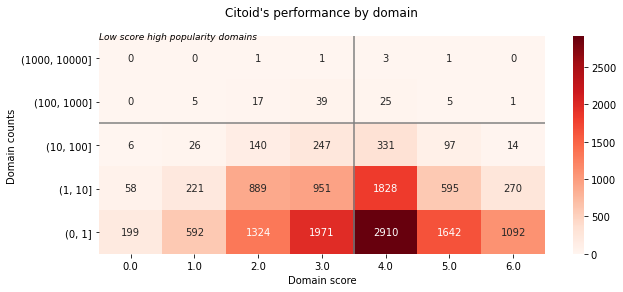

In [17]:
plot_data = citoid_eval[["domain", "domain_score", "domain_counts"]].copy().drop_duplicates()

plot_data["domain_score"] = round(plot_data["domain_score"])
plot_data["domain_counts_bin"] = pd.cut(plot_data["domain_counts"], [0, 1, 10, 100, 1000, 10000])

plot_data = plot_data.groupby(by=["domain_score", "domain_counts_bin"])["domain"].count()
plot_data = plot_data.reset_index().pivot("domain_counts_bin", "domain_score", "domain").fillna(0)
plot_data = plot_data.reindex(plot_data.index[::-1])

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
sns.heatmap(plot_data, cmap="Reds", annot=True, fmt=".0f", ax=ax)

ax.set_title("Citoid's performance by domain", pad=20)
ax.set_ylabel("Domain counts")
ax.set_xlabel("Domain score")
ax.text(x=0, y=0, s="Low score high popularity domains", va="center", fontsize=9, fontstyle="italic")
ax.axhline(2, color='grey')
ax.axvline(4, color='grey')

plt.savefig("plots/domain_score_popularity_heatmap.png")
plt.show()

In this plot, we can observe that the majority of the domains are cited a 10 times or less (darker areas correspond to (0-1] and (1-10] counts). For the automatic generation of translation test files we decided to select domains being cited more than 100 times in our evaluation corpus and having a score of 3 correct fields or less (upper left quadrant).

Some additional observations about the manual citations:

1. In many cases, there is no data for the evaluated fields


In [28]:
missing_up_to_3_fields = (citoid_eval[manual_metadata].applymap(len) > 0).sum(axis=1) < 3
citoid_eval[missing_up_to_3_fields][manual_metadata].sample(5)

,title_manual,author_last_manual,author_first_manual,pub_date_manual
31987,[neil young and crazy horse spent 11 magical d...,[colorado sun],[],[]
88967,[the irish charts - search results - frozen],[],[],[]
64500,"[jinjer (20 may, 2016)]",[anders ekdahl - ''battle helm.com''],[],[]
40830,[the 1996 pazz & jop critics poll],[],[],[]
30074,[ellen wilkinson (1891-1947) labour politician...,[],[],[]


We will filter these cases because an empty translation test is not useful.

2. Sometimes, manual citations contain wikicode

In [33]:
## NH
data_with_wikicode = [34454, 37306, 52070, 62452, 67658]
citoid_eval.iloc[data_with_wikicode][manual_metadata]

,title_manual,author_last_manual,author_first_manual,pub_date_manual
34454,[{{lang|en|the country wife}}],[{{lang|en|internet movie database}}],[],[2011]
37306,[''{{langue|en|hollow knight}}'' revient avec ...,[puyo],[],[2017]
52070,[sense and sensibility ''(introduction)''],[margaret doody],[],[2004]
62452,[''{{langue|en|charts}}'' japon : ''pokemon'' ...,[puyo],[],[2002]
67658,[lorde&nbsp;- new music],[lachno],[james],[2013-09-11]


We will exclude these citations because we do not want to generate config files having wikicode in the goal since it is not currently supported by Web2Cit.

In sum, to be elegible for generating a translation test file, a citation must:

- have a success score equal or lower than 50% (we prioritize domains for which Citoid's performance can be improved)
- belong to a domain cited more than 100 times in our corpus of evaluated URLs (we are interested in high frequency domains)
- have information for at least 3 of the following 4 fields: title, author_first, author_last, and pub_date (an empty translation test is not useful)
- do not contain wikicode (not currently supported by Web2Cit)

In [34]:
## filter by required metadata
mask = (citoid_eval[manual_metadata].applymap(len) > 0).sum(axis=1) > 2
citations4conf = citoid_eval[mask]

In [ ]:
## NH
## filter wikicode

In [36]:
## filter by domain frequency
popularity_threshold = 100
citations4conf = citations4conf[citations4conf["domain_counts"] > popularity_threshold]

In [35]:
## filter by domain score
score_threshold = 3 # max score is 6
citations4conf = citations4conf[citations4conf["domain_score"] <= score_threshold]

In [37]:
print(f"We have {len(citations4conf)} citations left")

We have 7119 citations left


In [38]:
## Sort by domain score, from lower to higher
citations4conf = citations4conf.sort_values(by=["domain_score"], ascending=True)

In [39]:
print(f"We have {len(citations4conf['domain'].drop_duplicates())} domains left")

We have 40 domains left


These are the domains having the lowest scores and higher citation frequency:

In [40]:
citations4conf[["domain","domain_score","domain_counts"]].drop_duplicates()

,domain,domain_score,domain_counts
27707,nl.newsbank.com,1.128000,125
15234,darwin-online.org.uk,1.288462,156
1198,docs.newsbank.com,1.328671,143
2765,tvbythenumbers.zap2it.com,1.405405,111
6870,www.ibiblio.org,1.493976,166
49381,people.com,1.542484,153
37939,news.google.com,1.543237,902
26360,usatoday30.usatoday.com,1.723529,170
76485,ew.com,1.757143,350
45346,www.robertchristgau.com,1.793939,165


For each domain, we keep the two citations having the lowest score.

In [41]:
## URL selection
citations4conf = citations4conf.sort_values(by="citoid_success").groupby("domain").head(2)

In [42]:
citations4conf.drop_duplicates(subset=["domain"]).sort_values(by="domain_counts", ascending=False).head(3)[["domain", "domain_counts"]]

,domain,domain_counts
28890,www.telegraph.co.uk,1116
50979,news.google.com,902
24816,www.eurogamer.net,785


## 4. Recover metadata without preprocessing

The data in our dataframe has been previously normalized (see Data normalization section in our [evaluation notebook](https://github.com/hdcaicyt/Web2Cit-research/blob/main/understand-citoid-coverage.ipynb)). For the configuration files, we are interested in the original metadata.

In [44]:
## This file contains the manual citations metadata before preprocessing
manual_before_preproc = pd.read_csv("data/citations_metadata_only_year.csv.gz")

cols = ['title','author_last', 'author_first', 'pub_date'] # 'pub_source' will not be used

manual_before_preproc = manual_before_preproc.drop_duplicates(subset=["url"], keep="first")

for col in cols:
    manual_before_preproc[col] = manual_before_preproc[col].fillna('None').map(eval)

In [45]:
manual_before_preproc.columns

Index(['article_title', 'article_url', 'page_id', 'revid', 'wiki_lang', 'url',
       'source_type', 'source_type_map', 'title', 'title_clean', 'author_last',
       'author_last_clean', 'author_first', 'author_first_clean', 'pub_date',
       'pub_date_clean', 'pub_date_control', 'pub_date_only_year',
       'pub_source', 'pub_source_clean'],
      dtype='object')

In [46]:
manual_before_preproc = manual_before_preproc.set_index("url").reindex(columns=cols)
manual_before_preproc.shape

(382983, 4)

Replace data in dataframe of top cited domains with low score with data before preprocessing for 'title','author_last' and 'author_first'. 'pub_date' is not necessary because we will keep data transformed to YYYY-MM-DD and 'pub_source' is not necessary because it will not be mapped to the config file, as explained above.

In [47]:
cols = ['title','author_last', 'author_first'] ## do not overwrite pub_date!

for col in cols:
    citations4conf[f"{col}_manual"] = manual_before_preproc.loc[ citations4conf["url"], col ].values

In [48]:
citations4conf[manual_metadata].sample(6)

,title_manual,author_last_manual,author_first_manual,pub_date_manual
54018,[Review: ‘Scream’],[Klady],[Leonard],[1996-12-21]
78644,[On the Origin of Species],[Darwin],[Charles],[1861]
32904,[A New Sun: The Solar Results From Skylab],[Eddy],[J.],[1979]
50476,[Consumer Guide: Turkey Shoot],[Christgau],[Robert],[1996-12-03]
27707,[Bad Rap There Was as Much Action Outside the ...,[Allen],[Carl],[1994-01-07]
62384,"[James Joyce, a new Irish novelist]",[Quinn],[John],[]


In [ ]:
citations4conf.to_csv("data/citations_for_config_files.csv", index=False)

## 5. Build translation tests files

* If we do not have metadata for a field in our selected citations ("[]"), we exclude the field from the configuration file
* We do not include itemType metadata because in the results of the Citoid's evaluation research we saw it is not reliable information even if there is a match between Citoid data and manual data (see Web2Cit Research [report](https://meta.wikimedia.org/wiki/Web2Cit/Research/report))
* For title and date fields, only one value is admitted in the configuration file. If we have more than one value in our selection, we include the exact match
* For authorLast and authorFirst, if we have metada, we map it directly

In [49]:
## map evaluation fieldnames to w2c fieldnames
eval_w2c = {
    'title_manual': 'title',
    'author_first_manual': 'authorFirst',
    'author_last_manual': 'authorLast', 
    'pub_date_manual': 'date',
}

def add_field(d, fieldname, row):
    el = {"fieldname": eval_w2c[fieldname]}
    el["goal"] = row[fieldname]
    d["fields"].append(el)
    return d


def row_to_json(row):
    '''
    Transforms row from evaluation df to w2c configuration file
    input: row
    output: json
    '''
    d = {}
    path = urlparse(row["url"]).path
    query = urlparse(row["url"]).query
    d["path"] = f"{path}?{query}" if query else path
    d["@comment"] = "Automatically created. See https://github.com/hdcaicyt/Web2Cit-research/blob/main/create-config-files.ipynb"
    d["fields"] = []
            
    for fieldname in ['title_manual','author_first_manual','author_last_manual', 'pub_date_manual']:
        if row[fieldname]:
            if fieldname == 'author_first_manual' or fieldname == 'author_last_manual':
                add_field(d, fieldname, row)
            else:
                ## cases of more than one value in title or pub_date
                if len(row[fieldname]) > 1:
                    name = fieldname.replace("_manual", "")
                    ## if the comparison score is 1, there was a match with Citoid data
                    if row[f"comp_{name}"] == 1:
                            el = {"fieldname": eval_w2c[fieldname]}
                            el["goal"] = row[f"{name}_citoid"]
                            d["fields"].append(el)
                else:
                    add_field(d, fieldname, row)
        ## cases of missing data:
        ## do not add fieldname to config file
    return d

In [ ]:
os.makedirs("data/translation_tests", exist_ok=True)

for ix, row in citations4conf.iterrows():
    el = row_to_json(row)
    domain = urlparse(row["url"]).netloc
    revdomain = ".".join(domain.split(".")[::-1])
    fp = f"data/config_files/{revdomain}.tests.json"
    
    if not os.path.isfile(fp):
        with open(fp, "w") as fo:
            json.dump([el], fo, indent=4)
    else:
        ## Add 2nd config
        with open(fp) as fi:
            config = json.load(fi)
            config.append(el)
        
        with open(fp, "w") as fo:
            json.dump(config, fo, indent=4)
            

## 6. Upload files